In [1006]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from scipy.stats import multivariate_normal
from matplotlib import cm
from scipy.stats import norm
from scipy.special import erf
from scipy.optimize import minimize
from scipy.special import logsumexp

## MC Integration

In [1007]:
def f(x):
    return (np.e)**x -4*x**2 + x**3 + 1

true_value = 1.634948495125712
n = 1000
#Normal MC
x1 = np.random.uniform(0,1,n)
mc = np.mean(f(x1))
error1 = np.abs(true_value - mc)
StDev1 = np.sqrt(np.var(f(x1))/n)

#MC with Antithetic Variables
x2 = 1 - x1
mc_at = 0.5*np.mean(f(x1)) + 0.5*np.mean(f(x2))
error2 = np.abs(true_value - mc_at)
StDev2 = np.sqrt(np.var(0.5*f(x1) + 0.5*f(x2))/n)

print(f"True value: {true_value}")
print()
print("Normal Monte Carlo:")
print(f"Value: {mc:.6f}, Absolute Error: {error1:.6f}, StDev:{StDev1:.6f}")
print()
print("Monte Carlo with Antithetic Variables:")
print(f"Value: {mc_at:.6f}, Absolute Error: {error2:.6f}, StDev:{StDev2:.6f}")

True value: 1.634948495125712

Normal Monte Carlo:
Value: 1.635702, Absolute Error: 0.000754, StDev:0.013487

Monte Carlo with Antithetic Variables:
Value: 1.634361, Absolute Error: 0.000588, StDev:0.003922


## Gaussian Process

<div class="alert alert-block alert-info">

The partitioned Gaussian vector:
$$
\begin{bmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{bmatrix} \sim \mathcal{N}\left( \begin{bmatrix} \boldsymbol{\mu}_1 \\ \boldsymbol{\mu}_2 \end{bmatrix}, \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix} \right),
$$

$$
\boldsymbol{\mu}_{2|1} = \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1),
$$
$$
\Sigma_{2|1} = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}.
$$


Let:
$$
\mathbf{x}_1 = \mathbf{f}, \quad \mathbf{x}_2 = \mathbf{f}_*, \quad \boldsymbol{\mu}_1 = \mathbf{0}, \quad \boldsymbol{\mu}_2 = \mathbf{0},
$$
$$
\Sigma_{11} = K(X, X), \quad \Sigma_{12} = K(X, X_*), \quad \Sigma_{21} = K(X_*, X), \quad \Sigma_{22} = K(X_*, X_*).
$$

Then:
$$
p\left( \begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \end{bmatrix} \middle| X, X_* \right) = \mathcal{N}\left( \begin{bmatrix} \mathbf{0} \\ \mathbf{0} \end{bmatrix}, \begin{bmatrix} K(X, X) & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*) \end{bmatrix} \right),
$$

---

The posterior $\textbf{mean}$ is:
$$
\begin{aligned}
\boldsymbol{\mu}_{\mathbf{f}_* | \mathbf{f}} &= \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1)\\ &= K(X_*, X) K(X, X)^{-1} \mathbf{f}.
\end{aligned}
$$

The posterior $\textbf{covariance}$ is:
$$
\begin{aligned}
\Sigma_{\mathbf{f}_* | \mathbf{f}} &= \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}\\ &= K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*).
\end{aligned}
$$
  
</div>

#### 1D Gaussian Process

In [1008]:
def gp_predict1d(xs,ys,x_eval,kernel, s=1, l=1):
    
    x_eval = x_eval.reshape(-1,1)
    ys = ys.reshape(-1,1)
    
    K_xx = kernel(xs, xs, s, l)
    K_xs = kernel(x_eval, xs, s, l)
    K_sx = kernel(xs, x_eval, s, l)
    K_xx_eval = kernel(x_eval, x_eval, s, l)

    mu = K_xs @ np.linalg.solve(K_xx, ys)
    sig = K_xx_eval - K_xs @ np.linalg.solve(K_xx, K_sx)

    return mu.ravel(), sig + 1e-9*np.eye(sig.shape[0])

#Kernel 1
def rbf1d(x1,x2,s=10, l=0.2):
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(1,-1)
    dists = (x1-x2)**2/(2*l**2)
    return s**2*np.exp(-dists)

#Kernel 2
def matern1d(x1,x2,rho=1/5):
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(1,-1)
    return (1. + np.sqrt(3.)*np.abs(x1-x2)/rho)*np.exp(-np.sqrt(3.)*np.abs(x1-x2)/rho)


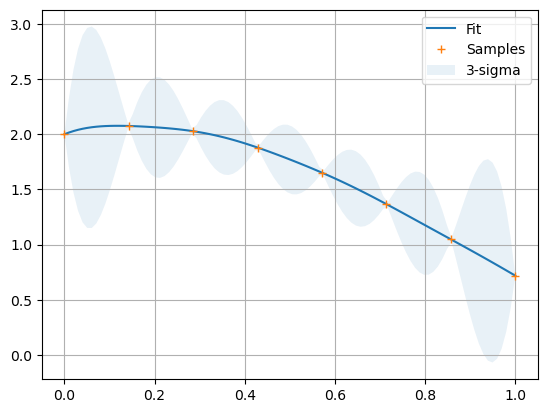

In [1009]:
x = np.linspace(0,1,8)
y = f(x)
s = 10
l = 0.2

x_eval = np.linspace(0,1,100)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d, s=s, l=l)
sig_diag = np.sqrt(np.diag(var_eval))

plt.plot(x_eval,mu_eval,label='Fit')
plt.plot(x,y,'+',label='Samples')
plt.fill_between(x_eval,mu_eval-3*sig_diag,mu_eval+3*sig_diag,alpha=0.1,label='3-sigma')
plt.legend()
plt.grid()
plt.show()

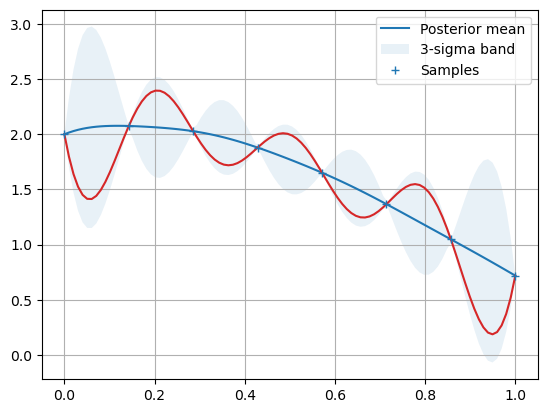

In [1010]:
#sample paths of the GP posterior
n_samples = 100000
samples = np.random.multivariate_normal(mu_eval, var_eval, size=n_samples)

#use trapezoidal rule weights for integration
dx = np.diff(x_eval)
weights = np.zeros_like(x_eval)
weights[1:-1] = (dx[:-1] + dx[1:])/2
weights[0] = dx[0]/2
weights[-1] = dx[-1]/2

#compute integrals and find 1% with lowest values
integrals = samples@weights
n_bottom = int(0.01*n_samples)
bottom_idx = np.argsort(integrals)[:n_bottom]
bottom_mean_curve = samples[bottom_idx].mean(axis=0)

#plot results
plt.plot(x_eval, mu_eval, label='Posterior mean', color='C0')
std_eval = np.sqrt(np.diag(var_eval))
plt.fill_between(
    x_eval,
    mu_eval - 3 * std_eval,
    mu_eval + 3 * std_eval,
    alpha=0.1,
    label='3-sigma band'
)
plt.plot(x_eval, bottom_mean_curve, color='C3')
plt.plot(x,y,'+',label='Samples')
plt.legend()
plt.grid()
plt.show()



#### 2D Gaussian Process

In [1011]:
def gp_predict2d(xs, ys, x_eval, kernel, l = 5, s = 5):

    ys = ys.reshape(-1,1)

    K = kernel(xs, xs, l, s) + 1e-6*np.eye(xs.shape[0])
    K_s = kernel(xs, x_eval, l, s)
    K_ss = kernel(x_eval, x_eval, l, s)


    # Predictive mean
    mu = K_s.T@np.linalg.solve(K, ys)

    # Predictive covariance
    v = np.linalg.solve(K, K_s)
    sig = K_ss - K_s.T@v

    return mu.ravel(), sig


def rbf2d(X1, X2, l=2, s=1):
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)

    diff = X1[:, None, :] - X2[None, :, :]
    sqdist = np.sum(diff**2, axis=2)
    return s**2*np.exp(-0.5/l**2*sqdist)

Relative Humidity is a function of temperature and dew point.

$$
e_s(T) = 6.1121 \, \exp\left(\left(18.678 - \frac{T}{234.5}\right) \cdot \left(\frac{T}{257.14 + T}\right)\right) \\

e = 6.1121 \, \exp\left(\left(18.678 - \frac{T_d}{234.5}\right) \cdot \left(\frac{T_d}{257.14 + T_d}\right)\right) \\
$$
$$
RH = 100 \times \frac{e}{e_s(T)}
$$

In [1012]:
def RH(T, Td):
    eT = 6.1121*np.exp((18.678 - T/234.5)*(T/(257.14 + T)))
    eTd = 6.1121*np.exp((18.678 - Td/234.5)*(Td/(257.14 + Td)))
    return 100*eTd/eT

For Temp: 9.6°C and DewP: 7.4°C
--------------------------------------
Relative humidity is: 86.1188%
The gp estimate is: 85.9958%
Error: 0.1231
95% CI: [85.2325%, 86.7591%]



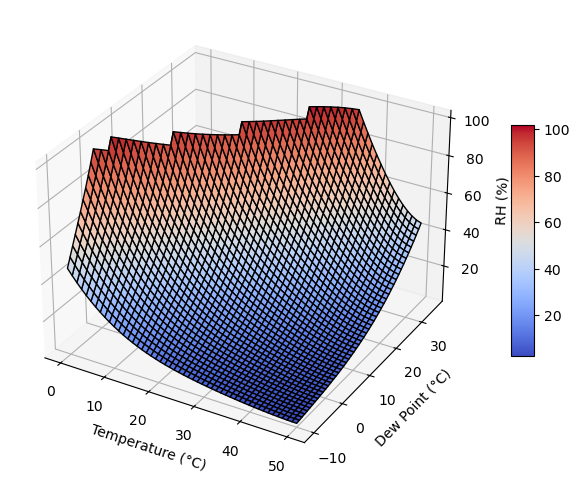

In [1013]:
#training data points
Temp = np.linspace(0,50,5)
DewP = np.linspace(-10,35,4)
T, D = np.meshgrid(Temp, DewP)
TD = np.column_stack([T.ravel(), D.ravel()])
rh = RH(TD[:,0], TD[:,1])

#evaluation points
Temp_eval = np.linspace(0,50,50)
DewP_eval = np.linspace(-10,35,50)
T_eval, D_eval = np.meshgrid(Temp_eval, DewP_eval)
TD_eval = np.column_stack([T_eval.ravel(), D_eval.ravel()])

#fit GP
l = 120
s = 27000
mu_grid, var_grid = gp_predict2d(TD, rh, TD_eval, kernel=rbf2d, l=l, s=s)
mu_grid = mu_grid.reshape(T_eval.shape)
mu_grid = np.where(D_eval > T_eval, np.nan, mu_grid)

#calculate relative humidity at random point
T = np.random.uniform(0,50,1)[0]
D = np.random.uniform(-10,T,1)[0]
relhum = RH(T,D)

#predict at same random point
gp_est, gp_var = gp_predict2d(TD, rh, (T,D), kernel=rbf2d, l=l, s=s)
low = gp_est - 1.96*np.sqrt(gp_var)
high = gp_est + 1.96*np.sqrt(gp_var)
error = np.abs(relhum - gp_est)

print(f'For Temp: {T:.1f}°C and DewP: {D:.1f}°C')
print('--------------------------------------')
print(f'Relative humidity is: {relhum:.4f}%')
print(f'The gp estimate is: {gp_est[0]:.4f}%')
print(f'Error: {error[0]:.4f}')
print(f'95% CI: [{low[0][0]:.4f}%, {high[0][0]:.4f}%]')
print()

#plot of GP surface
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_eval, D_eval, mu_grid, cmap=cm.coolwarm, edgecolor='k')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Dew Point (°C)')
ax.set_zlabel('RH (%)')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


## Bayesian Quadrature

$$
F(x) := \int_a^x f(t)\,dt
$$

where $f \sim \mathcal{GP}(m(x), k(x, x'))$,

---

Mean function:

$$
\mathbb{E}[F(x)] = \mathbb{E}\left[\int_a^x f(t) dt\right] = \int_a^x \mathbb{E}[f(t)] dt = \int_a^x m(t)\,dt
$$


$$
M(x) = \int_a^x m(t) dt
$$

Covariance function:


$$
K(x, x') := \operatorname{Cov}(F(x), F(x')) = \operatorname{Cov} \left( \int_a^x f(t) dt,\ \int_a^{x'} f(s) ds \right)
$$

Using Fubini's Theorem:
$$
K(x, x') = \int_a^x \int_a^{x'} \operatorname{Cov}(f(t), f(s))\, ds\, dt
= \int_a^x \int_a^{x'} k(t, s)\, ds\, dt
$$


$$
K(x, x') = \iint_{[a,x]\times[a,x']} k(t, s)\, dt\, ds
$$

---

$$
F(x) \sim \mathcal{GP}\left( M(x),\ K(x, x') \right)
$$

where:

* $M(x) = \int_a^x m(t)\,dt$
* $K(x, x') =  \int_a^x \int_a^{x'} k(t, s)\,ds\,dt$


$$
E[F|y] = M(x) + \textbf{k}_F^T K^{-1} \left( y-m(X) \right)
$$

$$
Var(F|y) = K(x,x) - \textbf{k}_F^T K^{-1} \textbf{k}_F
$$


where $\textbf{k}_F = \left( \int_a^x k(t, x_1)dt, \int_a^x k(t, x_2)dt, \cdots , \int_a^x k(t, x_n)dt \right)$

---

Lets start by deriving the mean of the integral

Using RBF Kernel $k(y,x) = \sigma_f^2\exp \left(-\frac{1}{2l^2} |x-y|^2 \right)$:
$$
\begin{aligned}
v[k] &= \int_a^x k(t,s) dt \\
     &= \int_a^x \sigma_f^2\exp \left(-\frac{1}{2l^2} |s-t|^2 \right) dt \\
\end{aligned}
$$
Let $l = \sigma$ hereon and factor out $\sigma_f^2 \cdot \sigma \sqrt{2\pi}$:
$$
\begin{aligned}
v[k] &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x \frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(s-t)^2}{2\sigma^2} \right) dt \\
     &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x k^*(t,s) dt \\
\end{aligned}
$$
Now working with just $k^*(t,s)$:
$$
\begin{aligned}
v^*[k] &= \int_a^x \frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(s-t)^2}{2\sigma^2} \right) dt \\
     &= \frac{1}{2} \left[1+\text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) \right] - \frac{1}{2} \left[1+\text{erf} \\ \left(\frac{a-s}{\sigma\sqrt{2}} \right) \right] \\
     &= \frac{1}{2} \left[ \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right]
\end{aligned}
$$

---

For the uncertainty we have to integrate again. 

$$
\begin{aligned}
vv[k] &= \int_a^x \int_a^x k(t,s) dsdt \\
      &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x \int_a^x k^*(t,s) dtds \\
      &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x \frac{1}{2}\text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2}\text{erf} \left(\frac{a-s}{\sigma\sqrt{2}} \right)ds \\
\end{aligned}
$$

Focusing on just $k^*(t,s)$, let $u_1 = \frac{x-s}{\sigma\sqrt{2}}$ and $u_2 = \frac{a-s}{\sigma\sqrt{2}}$  

$\implies$ $du_1 = du_2 = du = \frac{-1}{\sigma\sqrt{2}} \cdot ds$ 

$\implies$ $ds = -\sigma\sqrt{2} \cdot du$

$$
\begin{aligned}
vv^*[k] &= \int_a^x \frac{1}{2}\text{erf}(u_1)ds - \int_a^x\frac{1}{2}\text{erf}(u_2)ds \\
       &= \int_{\frac{x-a}{\sigma\sqrt{2}}}^0 -\frac{1}{2}\text{erf}(u_1) \cdot \sigma\sqrt{2} \cdot du_1 - \int_0^{\frac{a-x}{\sigma\sqrt{2}}} - \frac{1}{2}\text{erf}(u_2) \cdot \sigma\sqrt{2} \cdot du_2 \\
       &= \int_0^{\frac{x-a}{\sigma\sqrt{2}}} \frac{1}{2}\text{erf}(u) \cdot \sigma\sqrt{2} \cdot du - \int_{\frac{a-x}{\sigma\sqrt{2}}}^0 \frac{1}{2}\text{erf}(u) \cdot \sigma\sqrt{2} \cdot du \\
       &= \frac{\sigma\sqrt{2}}{2} \left(\int_0^{\frac{x-a}{\sigma\sqrt{2}}} \text{erf}(u)du + \int_0^{\frac{x-a}{\sigma\sqrt{2}}} \text{erf}(u)du \right) \\
       &= \sigma\sqrt{2} \left(\int_0^{\frac{x-a}{\sigma\sqrt{2}}} \text{erf}(u)du \right) \\
\end{aligned}
$$

Using $\int_0^\theta \text{erf}(u)du = \theta \, \text{erf}(\theta) + \frac{e^{-\theta^2} - 1}{\sqrt{\pi}}$, Let $\theta = \frac{x-a}{\sigma\sqrt{2}}$:

$$
\begin{aligned}
vv^*[k] &= \sigma\sqrt{2} \left(\theta \, \text{erf}(\theta) + \frac{e^{-\theta^2} - 1}{\sqrt{\pi}} \right) \\
        &= (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + \sigma\sqrt{2} \left( \frac{\exp{\left(-{\frac{(x-a)^2}{2 \sigma^2}}\right)} - 1}{\sqrt{\pi}} \right)\\
\end{aligned}
$$

---

So we have:
$$
\begin{align*}
v[k] &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) v^*[k] \\
     &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \, \left[\frac{1}{2} \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2} \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right] \\
     \\
vv[k] &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) vv^*[k] \\
      &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \left[(x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + \sigma\sqrt{2} \left( \frac{\exp{\left(-{\frac{(x-a)^2}{2 \sigma^2}}\right)} - 1}{\sqrt{\pi}} \right) \right] \\
      &= \sigma_f^2 \left[ \sigma \sqrt{2\pi} \, (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + 2 \sigma^2 \left( e^{-{\frac{(x-a)^2}{2 \sigma^2}}} - 1 \right) \right] \\
\end{align*}
$$



#### 1D Example

In [1014]:
def vk(input,lower, upper, s=1,l=1):
    return s**2*l*np.sqrt(2*np.pi)*(0.5*erf((upper-input)/(l*np.sqrt(2))) - 0.5*erf((lower-input)/(l*np.sqrt(2))))

def vvk(lower, upper, s=1, l=1):
    return s**2*(l*np.sqrt(2*np.pi)*(upper-lower)*erf((upper-lower)/(l*np.sqrt(2))) + 2*l**2*(np.exp(-(upper-lower)**2/(2*l**2)) - 1))

def integrate_rbf1d(x_eval,y_eval, lower, upper, s=1,l=1):
    
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    kxx = rbf1d(x_eval,x_eval.T,s,l)
    
    mu = vk(x_eval,lower,upper,s,l).reshape(1,-1)@np.linalg.solve(kxx,y_eval)
    var = vvk(lower,upper,s,l) - vk(x_eval,lower,upper,s,l).reshape(1,-1)@np.linalg.solve(kxx,vk(x_eval,lower,upper,s,l).reshape(-1,1))
    
    return mu, var

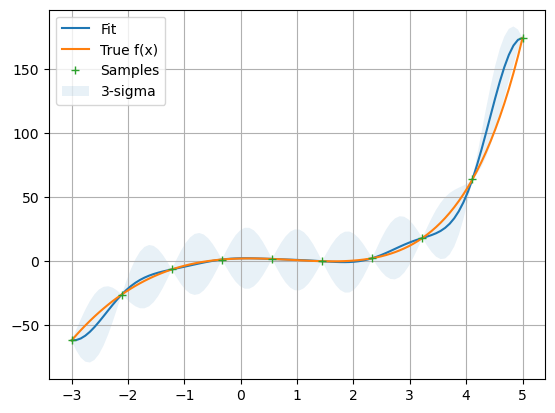

In [1015]:
def f(x):
    return (np.e)**x -4*x**2 + x**3 + 1

def F(x):
    return (np.e)**x + (1/4)*x**4 -(4/3)*x**3 + x

#integral of f(x) from lower to upper
lower = -3
upper = 5
true_value = F(upper) - F(lower)

#kernel hyperparameters
s = 25
l = 0.6
#sample n points
n = 10
x = np.linspace(lower,upper,n)
y = f(x)

#points to plot gp
x_eval = np.linspace(lower,upper,100)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d,s=s,l=l)
sig_diag = np.sqrt(np.diag(var_eval))

#real curve
y1 = f(x_eval)

#plot gp
plt.plot(x_eval,mu_eval,label='Fit')
plt.plot(x_eval,y1,label='True f(x)')
plt.plot(x,y,'+',label='Samples')
plt.fill_between(x_eval,mu_eval-3*sig_diag,mu_eval+3*sig_diag,alpha=0.1,label='3-sigma')
plt.legend()
plt.grid()
plt.show()

In [1016]:
print(f"True value: {true_value}")
print()
print("Bayesian Quadrature")
for n in [1,3,5,8,12,20,50,75]:
    x = np.linspace(lower,upper,n)
    y = f(x)
    I_mu, I_var = integrate_rbf1d(x,y,lower,upper,s,l)
    error = np.abs(true_value - I_mu[0][0])
    print(f"{n} pts:")
    print(f"Estimate: {I_mu[0][0]:.8f} , StDev: {np.sqrt(I_var[0][0]):.10f}")
    print(f"Absolute Error: {error:.8f}")
    print()

True value: 89.69670536754205

Bayesian Quadrature
1 pts:
Estimate: -46.58584661 , StDev: 81.9539849572
Absolute Error: 136.28255197

3 pts:
Estimate: 85.65111950 , StDev: 70.3513310707
Absolute Error: 4.04558587

5 pts:
Estimate: 97.62810317 , StDev: 46.4420036086
Absolute Error: 7.93139780

8 pts:
Estimate: 103.29411311 , StDev: 11.5178701979
Absolute Error: 13.59740774

12 pts:
Estimate: 94.59055269 , StDev: 2.0663194224
Absolute Error: 4.89384732

20 pts:
Estimate: 90.23076603 , StDev: 0.1801135663
Absolute Error: 0.53406066

50 pts:
Estimate: 89.69654318 , StDev: 0.0000356577
Absolute Error: 0.00016219

75 pts:
Estimate: 89.69670436 , StDev: 0.0000013487
Absolute Error: 0.00000101



#### 2D Example

## Run of VBMC

In [1017]:
def plot_GP_surrogate(X, y, X_new, y_pred_mean, y_pred_std, samples):
    plt.figure(figsize=(10, 6))

    plt.plot(X_new, y_pred_mean, lw=2, color='gray', label='GP Mean')
    plt.fill_between(X_new.ravel(),
                    y_pred_mean.ravel() - 2*y_pred_std.ravel(),
                    y_pred_mean.ravel() + 2*y_pred_std.ravel(),
                    color='lightgray', label='95% CI')


    plt.scatter(X, y, c='red', s=50, label='Observed')
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Log GP Surrogate")
    plt.legend(loc='upper left')
    plt.tight_layout()
    #plt.show()

In [1053]:
#In practice we wont know the the value of the parameter/s (obviously) and likelihoods will be difficult or expensive
def expensive_log_likelihood(mu1, mu2, sigma1, sigma2, obs):
    gauss1 = (1/(np.sqrt(2*np.pi)*sigma1))*np.exp(-0.5*((obs - mu1)/sigma1)**2)
    gauss2 = (1/(np.sqrt(2*np.pi)*sigma2))*np.exp(-0.5*((obs - mu2)/sigma2)**2)
    

    likelihood = 0.5*gauss1 + 0.5*gauss2
    log_likelihood = np.log(likelihood)
    return log_likelihood

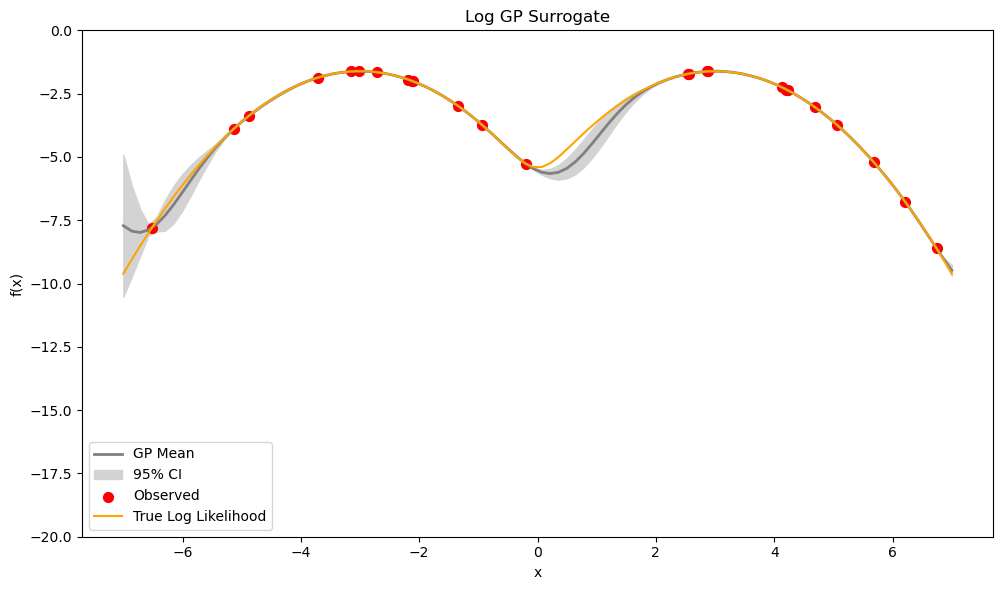

In [1054]:
n = 25
mu1_true=-3
mu2_true=3
sigma1_true=1
sigma2_true=1
lower = mu1_true - 4*sigma1_true
upper = mu2_true + 4*sigma2_true

#vbmc traditionally samples much smarter than randomly but here we sample 3 random points and infer a likelihood
x = np.sort(np.random.uniform(lower,upper,n)).reshape(-1,1)
y = expensive_log_likelihood(mu1_true,mu2_true,sigma1_true,sigma2_true,x.ravel()).reshape(-1,1)

#hyperparameters for gp
s = 5
l = 1

#plot gp
x_eval= np.linspace(lower,upper,100).reshape(-1,1)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d,s=s,l=l)
sig_diag = np.sqrt(np.diag(var_eval))

plot_GP_surrogate(x, y, x_eval, mu_eval, sig_diag, samples=[])


x_vals = np.linspace(lower, upper, 100).ravel().reshape(-1,1)
log_likelihood = expensive_log_likelihood(mu1_true,mu2_true,sigma1_true,sigma2_true,x_vals).reshape(-1,1)

plt.plot(x_vals, log_likelihood, label='True Log Likelihood', color='orange')
plt.ylim(-20,0)
plt.legend()
plt.show()


### Find variational posterior

$$
\log p(\mathbf{x}) = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] - \mathbb{E}_q[\log q(\mathbf{z})]}_{= ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{\ge 0}
$$

$$
ELBO = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})]}_{=\text{Expected Log Joint}} + \underbrace{\left(-\mathbb{E}_q[\log q(\mathbf{z})]\right)}_{=\text{Entropy of Q}}
$$



In [1020]:
#MC estimate of entropy of a bimodal Gaussian
def bimodal_entropy(mu1, mu2, sigma1, sigma2, n_samples=100000):
    #sample from mixture
    mix = np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])
    samples = np.where(mix == 0, np.random.normal(mu1, sigma1, n_samples),
                                 np.random.normal(mu2, sigma2, n_samples))
    
    #compute pdf at sampled points
    pdf = 0.5*(1/(np.sqrt(2*np.pi)*sigma1))*np.exp(-0.5*((samples - mu1)/sigma1)**2) + \
          0.5*(1/(np.sqrt(2*np.pi)*sigma2))*np.exp(-0.5*((samples - mu2)/sigma2)**2)\

    #return entropy
    return -np.mean(np.log(pdf))


def elbo(params, x, y, s=1, l=1):
    mu1, mu2, log_s1, log_s2 = params
    
    #ensure log_s1 and log_s2 are within reasonable bounds
    s1_q = np.exp(np.clip(log_s1, -3, 3))
    s2_q = np.exp(np.clip(log_s2, -3, 3))

    lower = mu1 - 3.5*s1_q
    upper = mu2 + 3.5*s2_q

    #compute expected log joint
    z = np.linspace(lower, upper, 100)
    mu_gp, _ = gp_predict1d(x, y, z, kernel=rbf1d, s=s, l=l)
    q_pdf = (0.5*(1/(np.sqrt(2*np.pi)*s1_q))*np.exp(-0.5*((z - mu1)/s1_q)**2) + \
             0.5*(1/(np.sqrt(2*np.pi)*s2_q))*np.exp(-0.5*((z - mu2)/s2_q)**2))
    integrand = mu_gp.ravel()*q_pdf
    expected_log_joint = np.trapezoid(integrand, z)

    #entropy of Gaussian q
    entropy_q = bimodal_entropy(mu1=mu1, mu2=mu2, sigma1=s1_q, sigma2=s2_q)

    #negative ELBO
    return (-expected_log_joint - entropy_q).item()


In [1021]:
#intial parameters
params = [0.0, 0.0, 0.0, 0.0]
n_iter = 1000
eps = 1e-5
lr = 0.001

for i in range(n_iter):
    grads = np.zeros_like(params)

    #finite difference gradients
    for j in range(len(params)):
        params_eps = params.copy()

        params_eps[j] += eps
        f_plus = elbo(params_eps, x, y, s, l)

        params_eps[j] -= 2*eps
        f_minus = elbo(params_eps, x, y, s, l)
        
        grads[j] = (f_plus - f_minus)/(2*eps)

    params -= lr*grads

    if (i+1) % 50 == 0:
        print(f"Iter {i+1}: mu1={params[0]:.4f}, \
        mu2={params[1]:.4f}, \
        s1={np.exp(params[2]):.4f}, \
        s2={np.exp(params[3]):.4f}, \
        ELBO={-elbo(params,x,y,s,l):.4f}")

mu1_opt, mu2_opt, log_s1_opt, log_s2_opt = params
s1_opt = np.exp(log_s1_opt)
s2_opt = np.exp(log_s2_opt)

print("Optimised mu1:", mu1_opt)
print("Optimised mu2:", mu2_opt)
print("Optimised s1:", s1_opt)
print("Optimised s2:", s2_opt)


Iter 50: mu1=-1.3383,         mu2=1.7968,         s1=1.4408,         s2=3.7135,         ELBO=-0.9277
Iter 100: mu1=-0.2990,         mu2=2.2054,         s1=7.1398,         s2=5.8319,         ELBO=-0.0505
Iter 150: mu1=-0.5766,         mu2=2.4218,         s1=7.2756,         s2=7.3065,         ELBO=0.2289
Iter 200: mu1=-2.1536,         mu2=3.3128,         s1=2.0053,         s2=3.7307,         ELBO=-0.7121
Iter 250: mu1=-1.4337,         mu2=4.9216,         s1=3.3492,         s2=14.4683,         ELBO=0.9440
Iter 300: mu1=-2.1772,         mu2=1.8831,         s1=11.9034,         s2=17.0208,         ELBO=2.0775
Iter 350: mu1=-3.8604,         mu2=1.5059,         s1=15.0668,         s2=76.9623,         ELBO=2.6047
Iter 400: mu1=-6.0152,         mu2=2.9315,         s1=265.1023,         s2=629.1089,         ELBO=2.9715
Iter 450: mu1=-5.4822,         mu2=1.3520,         s1=74.6572,         s2=66.7763,         ELBO=2.9504
Iter 500: mu1=-6.7031,         mu2=0.8897,         s1=245.4245,         s2=15.

In [ ]:
#This should theoretically be the highest ELBO we can get
-elbo([mu1_true,mu2_true,np.log(sigma1_true),np.log(sigma2_true)],x,y,s,l)

-0.01961371920184929

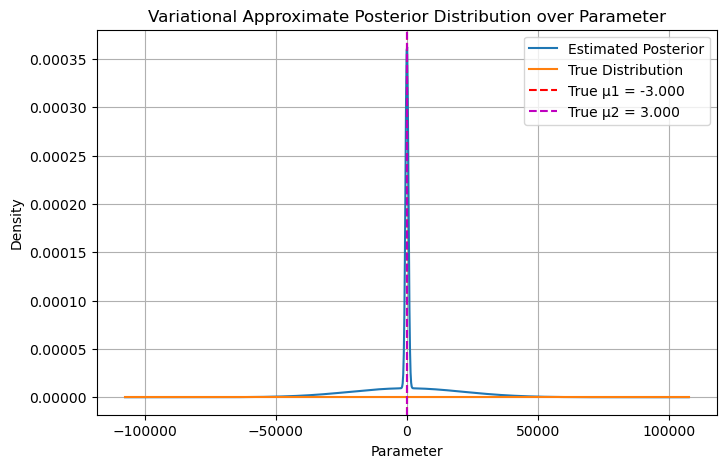

In [ ]:
x_min = min(mu1_opt - 5*s1_opt, mu2_opt - 5*s2_opt)
x_max = max(mu1_opt + 5*s1_opt, mu2_opt + 5*s2_opt)
x_vals = np.linspace(x_min, x_max, 1000)

#estimated mixture PDF
pdf_vals = 0.5*norm.pdf(x_vals, loc=mu1_opt, scale=s1_opt) + \
           0.5*norm.pdf(x_vals, loc=mu2_opt, scale=s2_opt)

#true mixture PDF
true_vals = 0.5*norm.pdf(x_vals, loc=mu1_true, scale=sigma1_true) + \
            0.5*norm.pdf(x_vals, loc=mu2_true, scale=sigma2_true)

#compare estimated and true distributions
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Estimated Posterior')
plt.plot(x_vals, true_vals, label='True Distribution')
plt.axvline(mu1_true, color='r', linestyle='--', label=f'True μ1 = {mu1_true:.3f}')
plt.axvline(mu2_true, color='m', linestyle='--', label=f'True μ2 = {mu2_true:.3f}')
plt.title('Variational Approximate Posterior Distribution over Parameter')
plt.xlabel('Parameter')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()